# Accident Detection System

## 1. Introduction

dataset in use https://www.kaggle.com/datasets/fahaddalwai/cctvfootagevideo/data for this demo

## 2. Importing libraries

In [1]:
!pip install tensorflow

  Obtaining dependency information for numpy<2.1.0,>=1.26.0 from https://files.pythonhosted.org/packages/c1/ca/2f384720020c7b244d22508cb7ab23d95f179fcfff33c31a6eeba8d6c512/numpy-2.0.2-cp311-cp311-macosx_14_0_arm64.whl.metadata
  Using cached numpy-2.0.2-cp311-cp311-macosx_14_0_arm64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp311-cp311-macosx_14_0_arm64.whl (5.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 2.0.2 which is incompatible.
scipy 1.11.1 requires nump

In [2]:
!pip install numpy==1.24.3

  Obtaining dependency information for numpy==1.24.3 from https://files.pythonhosted.org/packages/ee/6c/7217a8844dfe22e349bccbecd35571fa72c5d7fe8b33d8c5540e8cc2535c/numpy-1.24.3-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Using cached numpy-1.24.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.6 kB)
Using cached numpy-1.24.3-cp311-cp311-macosx_11_0_arm64.whl (13.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


In [4]:
# frame extraction

def extract_frames(video_path, frames_dir, skip_frames=1):
    """
    Extract frames from a video and save them as images.

    Parameters:
    - video_path: Path to the video file.
    - frames_dir: Directory to save extracted frames.
    - skip_frames: Extract every nth frame to reduce data size.
    """
    os.makedirs(frames_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video: {total_frames}")

    for _ in tqdm(range(total_frames), desc="Extracting frames"):
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % skip_frames == 0:
            frame_path = os.path.join(frames_dir, f"frame_{frame_count:05d}.jpg")
            cv2.imwrite(frame_path, frame)
            saved_count += 1
        frame_count += 1

    cap.release()
    print(f"Extracted and saved {saved_count} frames.")

# Parameters
video_path = './data/raw_video.mp4'
frames_dir = './data/frames/'
skip_frames = 5  # Extract every 5th frame to reduce data size

# Extract frames
extract_frames(video_path, frames_dir, skip_frames)

[ WARN:0@6.582] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@6.582] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin0 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@6.582] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@6.582] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/c

Total frames in video: 2298


Extracting frames: 100%|███████████████████| 2298/2298 [00:03<00:00, 762.79it/s]

Extracted and saved 460 frames.


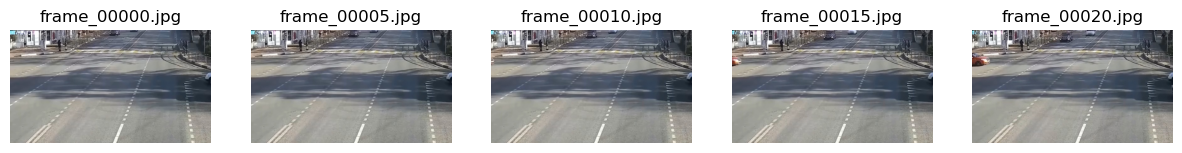

In [5]:
## annotation

# Initialize an empty DataFrame for annotations
annotations = pd.DataFrame(columns=['frame_number', 'label'])

# List all frame files
frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.jpg')])

# Display sample frames for manual labeling
num_samples = 5
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    img = cv2.imread(os.path.join(frames_dir, frame_files[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"{frame_files[i]}")
    plt.axis('off')
plt.show()


In [43]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# 1. Define Paths and Parameters
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

img_height = 250
img_width = 250
batch_size = 100

In [44]:
# 2. Load Datasets with `image_dataset_from_directory`
# This approach automatically handles batching and shuffling

training_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

# Save class names before applying performance optimizations
class_names = training_data.class_names

Found 791 files belonging to 2 classes.
Found 98 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [45]:
# 3. Configure Dataset for Performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size=AUTOTUNE)

In [50]:
# 4. Define the CNN Model
model = models.Sequential([
    layers.Rescaling(1./255),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.5102 - loss: 2.8760 - val_accuracy: 0.5306 - val_loss: 0.6911
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.5525 - loss: 0.6805 - val_accuracy: 0.5306 - val_loss: 0.6760
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.6409 - loss: 0.6352 - val_accuracy: 0.6224 - val_loss: 0.6559
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.6709 - loss: 0.5790 - val_accuracy: 0.6531 - val_loss: 0.6309
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.6897 - loss: 0.5336 - val_accuracy: 0.7959 - val_loss: 0.5895
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.7787 - loss: 0.4547 - val_accuracy: 0.8061 - val_loss: 0.5563
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.7943 - loss: 0.4256 - val_accuracy: 0.7143 - val_loss: 0.5592
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.8287 - loss: 0.3766 - val_accuracy: 0.8367 - val_loss: 0.5070
Epoch 9/

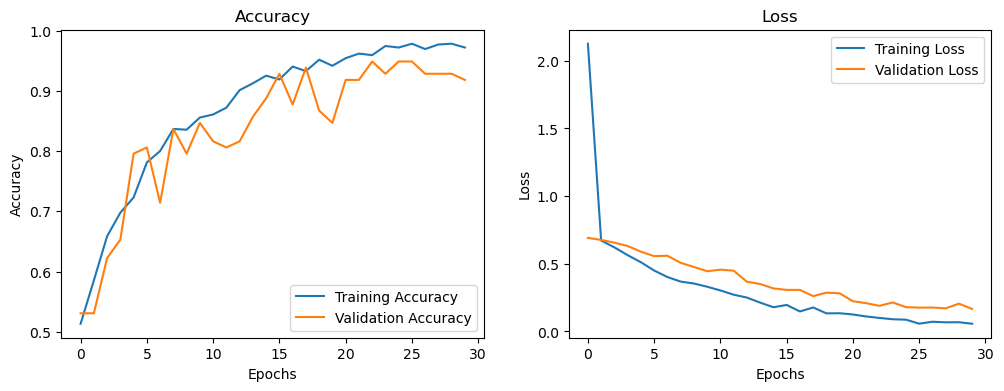

In [51]:
# 7. Plot Training and Validation Metrics

history = model.fit(training_data, validation_data=validation_data, epochs=30)

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9500 - loss: 0.1143
Test Accuracy: 0.95
Test Loss: 0.11
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


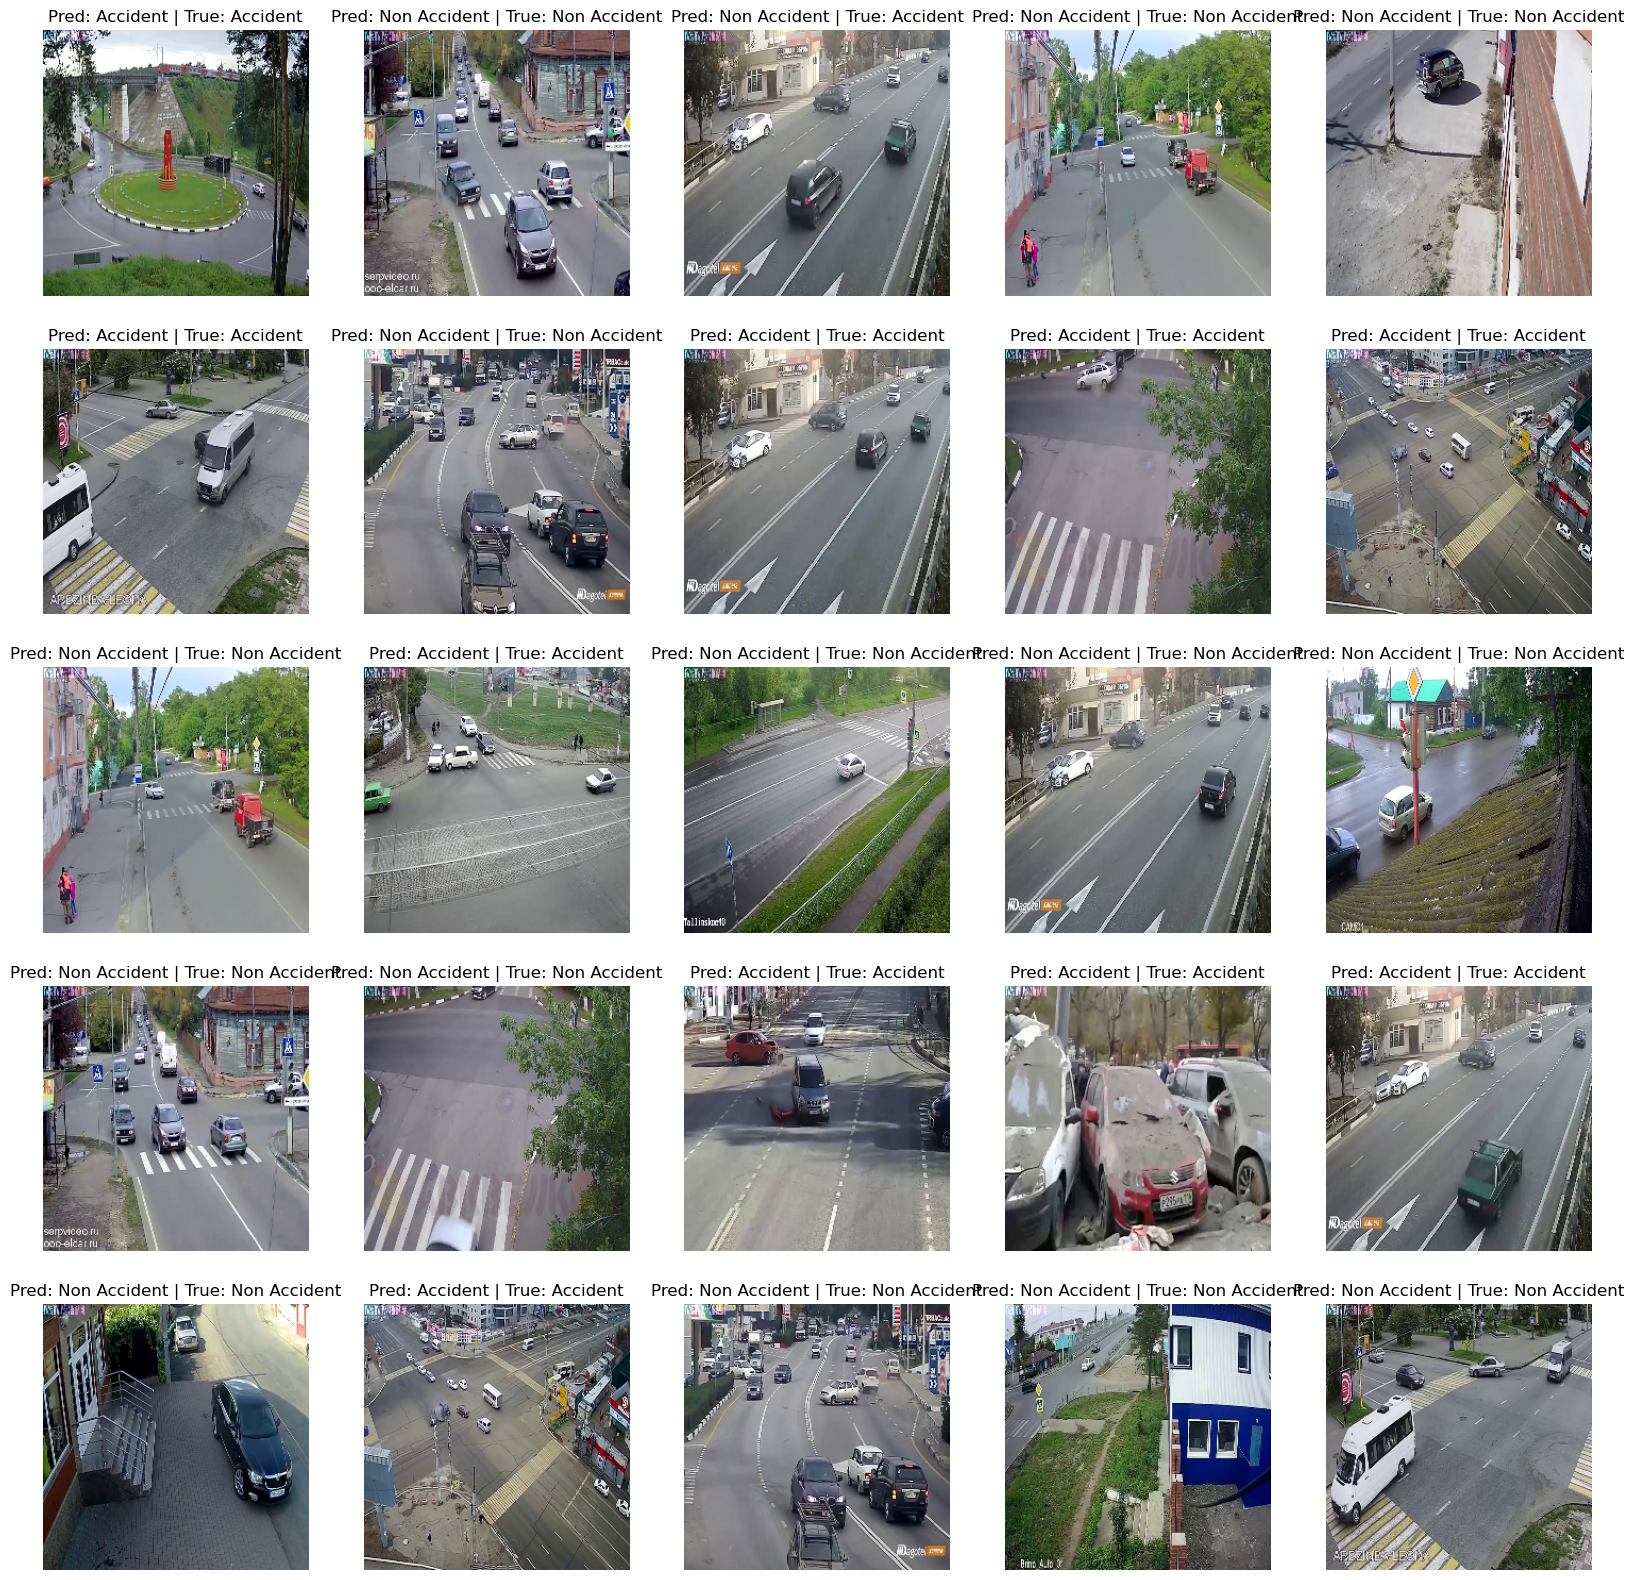

In [52]:
# 8. Evaluate on Testing Data
test_loss, test_accuracy = model.evaluate(testing_data)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# 9. Visualize Predictions on Testing Data
plt.figure(figsize=(20, 20))
for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    pred_labels = [class_names[np.argmax(pred)] for pred in predictions]
    true_labels = [class_names[label] for label in labels]

    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {pred_labels[i]} | True: {true_labels[i]}")
        plt.axis("off")

plt.show()


In [53]:
test_loss, test_accuracy = model.evaluate(testing_data)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9500 - loss: 0.1143
Test Accuracy: 0.95
Test Loss: 0.11


In [54]:
# Save the trained model
model.save("accident_detection_model.keras")

In [18]:
predictions

array([[9.99998569e-01, 1.42623901e-06],
       [1.70431963e-06, 9.99998331e-01],
       [5.07761717e-01, 4.92238283e-01],
       [2.56627914e-04, 9.99743462e-01],
       [5.12438547e-03, 9.94875610e-01],
       [9.99272466e-01, 7.27537205e-04],
       [1.53282699e-07, 9.99999881e-01],
       [9.97146845e-01, 2.85323453e-03],
       [9.99734461e-01, 2.65541777e-04],
       [9.99999881e-01, 6.41166906e-08],
       [2.17423949e-04, 9.99782622e-01],
       [9.85936224e-01, 1.40637457e-02],
       [2.08139196e-01, 7.91860819e-01],
       [1.76205113e-08, 1.00000000e+00],
       [5.99563529e-04, 9.99400377e-01],
       [2.86970317e-04, 9.99713004e-01],
       [1.26920259e-02, 9.87308025e-01],
       [4.58683789e-01, 5.41316152e-01],
       [9.99768376e-01, 2.31620157e-04],
       [4.85463515e-02, 9.51453626e-01],
       [2.98634078e-03, 9.97013688e-01],
       [1.00000000e+00, 1.16868559e-08],
       [1.17980790e-08, 1.00000000e+00],
       [4.83594078e-04, 9.99516368e-01],
       [1.989396

In [24]:
# 9. Visualize Predictions on Testing Data
print(testing_data.take(1))
for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    print(predictions)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
[[9.99998569e-01 1.42623901e-06]
 [1.70431963e-06 9.99998331e-01]
 [5.07761717e-01 4.92238283e-01]
 [2.56627914e-04 9.99743462e-01]
 [5.12438547e-03 9.94875610e-01]
 [9.99272466e-01 7.27537205e-04]
 [1.53282699e-07 9.99999881e-01]
 [9.97146845e-01 2.85323453e-03]
 [9.99734461e-01 2.65541777e-04]
 [9.99999881e-01 6.41166906e-08]
 [2.17423949e-04 9.99782622e-01]
 [9.85936224e-01 1.40637457e-02]
 [2.08139196e-01 7.91860819e-01]
 [1.76205113e-08 1.00000000e+00]
 [5.99563529e-04 9.99400377e-01]
 [2.86970317e-04 9.99713004e-01]
 [1.26920259e-02 9.87308025e-01]
 [4.58683789e-01 5.41316152e-01]
 [9.99768376e-01 2.31620157e-04]
 [4.85463515e-02 9.51453626e-01]
 [2.98634078e-03 9.97013688e-01]
 [1.00000000e+00 1.16868559e-08]
 [1.17980790e-08 1.00000000e+00]
 [4.83594078e-04 9.99516368e-01]
 [1.98939688e-06 9

In [25]:
# Save a test image from the dataset for consistent testing
for images, labels in testing_data.take(1):
    tf.keras.preprocessing.image.save_img("test_image.jpg", images[0])  # Saves the first image in the batch
    break


In [26]:
import tensorflow as tf
print(tf.__version__)


2.18.0


In [31]:
# Save model architecture to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save weights to a .weights.h5 file
model.save_weights("model.weights.h5")


In [33]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the saved model
loaded_model = load_model("accident_detection1_model.keras")

# Compare predictions on a sample batch from your test data
for images, labels in testing_data.take(1):
    original_predictions = model.predict(images)  # Predictions from the original model
    loaded_model_predictions = loaded_model.predict(images)  # Predictions from the loaded model

    # Check if both sets of predictions are the same
    print("Original Model Predictions:\n", original_predictions)
    print("Loaded Model Predictions:\n", loaded_model_predictions)

    # Optionally, calculate and print the difference between the predictions
    difference = np.abs(original_predictions - loaded_model_predictions)
    print("Difference between original and loaded model predictions:\n", difference)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
Original Model Predictions:
 [[1.15955146e-07 9.99999881e-01]
 [8.95900488e-01 1.04099564e-01]
 [9.92442906e-01 7.55703682e-03]
 [8.77237216e-09 1.00000000e+00]
 [9.71056283e-01 2.89436430e-02]
 [1.98088790e-04 9.99801874e-01]
 [2.95364327e-04 9.99704719e-01]
 [8.52616893e-07 9.99999166e-01]
 [1.61033645e-02 9.83896554e-01]
 [3.07479064e-09 1.00000000e+00]
 [8.80256891e-01 1.19743064e-01]
 [2.13027060e-01 7.86973000e-01]
 [2.99250660e-05 9.99970138e-01]
 [9.94776905e-01 5.22319507e-03]
 [9.99981940e-01 1.81290598e-05]
 [3.53935212e-01 6.46064818e-01]
 [9.99985337e-01 1.46277289e-05]
 [9.99069929e-01 9.30011156e-04]
 [1.15027666e-04 9.99884963e-01]
 [2.29717648e-06 9.99997735e-01]
 [9.93080139e-01 6.91988273e-03]
 [9.99985576e-01 1.44057858e-05]
 [2.87142630e-05 9.99971330e-01]
 [2.33629631e-04 9.99766350e-01]
 [2.66666547e-03 9.97333348e-01]
 [8.83567572e-01 1.16432436e-01]
 [1.44555641e-04 9.99855459e-01]
 [